# Import 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
import time
from time import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch
from torch import  nn, optim
import torchvision.models as models
from torchvision import transforms, datasets
from torchvision.models import swin_v2_t, swin_v2_b, efficientnet_b4
from torch.utils.data import DataLoader

from torch.cuda.amp.autocast_mode import autocast
from torch.cuda.amp.grad_scaler import GradScaler

from torcheval.metrics.aggregation.auc import AUC
from torcheval.metrics.functional.aggregation.auc import auc
from torcheval.metrics import MulticlassAUROC, MulticlassAccuracy, Mean

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

import loralib

from utils import save_model, save_plots, SaveBestModel

# Working folders

In [3]:
# Get the current working directory
current_directory = os.getcwd()

# Concatenate the current directory with additional directories
# train_dir = os.path.join(current_directory, "../ISIC2019_train/Image")
train_dir = os.path.join(current_directory, "../ISIC2019_train/Image_DullRazor")

val_dir = os.path.join(current_directory, "../ISIC2019_valDR")
print(train_dir)
print(val_dir)

/home/user/Dat/Vit/lora/Swin_From_Scratch/../ISIC2019_train/Image_DullRazor
/home/user/Dat/Vit/lora/Swin_From_Scratch/../ISIC2019_valDR


In [4]:
NUM_WORKERS = os.cpu_count()
total_images = 0
for i in os.listdir(train_dir):
    tmp = os.path.join(train_dir, i)
    for j in os.listdir(tmp):
        total_images += 1
print(total_images)
NUM_WORKERS

20264


12

# Datasets

In [5]:
# IMG_SIZE = 256
IMG_SIZE = 32


def create_dataloaders(
    train_dir: str, 
    val_dir: str,
    # transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
    
    train_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
#         transforms.CenterCrop((IMG_SIZE, IMG_SIZE)),
        
#         transforms.RandomHorizontalFlip(p=0.5),
#         transforms.RandomRotation(35),
        # transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], 
        #                      std=[0.229, 0.224, 0.225])
        ])    
    
    valid_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        
        # transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], 
        #                      std=[0.229, 0.224, 0.225])
        ]) 

    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    val_data = datasets.ImageFolder(val_dir, transform=valid_transform)
    
    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
    )
    val_dataloader = DataLoader(
      val_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
    )

    return train_dataloader, val_dataloader, class_names

In [6]:
BATCH_SIZE = 8

# Create data loaders
train_dataloader, val_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    val_dir=val_dir,
    # transform=manual_transforms, 
    batch_size=BATCH_SIZE,
    num_workers=1
)

train_dataloader, val_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f7b081e7070>,
 ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC'])

## class weight

In [7]:
# Calculate class Weight
class_weights = []
for i in os.listdir(train_dir):
    tmp = os.path.join(train_dir, i)
    total_in_folder = 0
    for j in os.listdir(tmp):
        total_in_folder += 1
    
    tmp_weight = 1 - (total_in_folder / total_images)
    class_weights.append(round(tmp_weight,3))
class_weights = torch.Tensor(class_weights)
print(class_names)
print(class_weights)

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']
tensor([0.8210, 0.4920, 0.9750, 0.8690, 0.9660, 0.9900, 0.9910, 0.8960])


# check gpu

In [8]:
# Move the model to the GPU if available
torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(len(class_names))
device

8


device(type='cuda', index=0)

# Init mode

In [9]:
# Assuming IMG_SIZE is defined
# IMG_SIZE = 224  # Define according to your needs
# IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Example using ResNet for similarity with EfficientNet's usage in TensorFlow

# model = swin_v2_b(weights='IMAGENET1K_V1', progress=True)
model = swin_v2_b(progress=True)

# model = efficientnet_b4(weights='IMAGENET1K_V1', progress=True)


# for param in model.parameters(): #freeze model
#     # param.requires_grad = False
#     param.requires_grad = False
    

# model = nn.Sequential(*list(model.children())[:-2])  # Removing the fully connected layer & avgpool

n_inputs = model.head.in_features
print(n_inputs)

model.head = nn.Sequential(
    nn.Linear(n_inputs, 256),
    # loralib.Linear(n_inputs,256,r=8),
    nn.ReLU(),
    
    # nn.Linear(256, 512),
    loralib.Linear(256,128,r=8),
    nn.ReLU(),
    
    
    nn.Linear(128, len(class_names)),
    # loralib.Linear(128, len(class_names), r=64)
)
    
# This sets requires_grad to False for all parameters
# loralib.mark_only_lora_as_trainable(model)

model = model.to(device)
print(model.head)
# print(model.classifier)

# # Freeze all layers except the final classification layer
# for name, param in model.named_parameters():
#     if "fc" in name:  # Unfreeze the final classification layer
#         param.requires_grad = True
#     else:
#         param.requires_grad = False

1024
Sequential(
  (0): Linear(in_features=1024, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=8, bias=True)
)


In [8]:
# class CIFAR10Model(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
#         self.act1 = nn.ReLU()
#         self.drop1 = nn.Dropout(0.3)
 
#         self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
#         self.act2 = nn.ReLU()
#         self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
#         self.flat = nn.Flatten()
 
#         self.fc3 = nn.Linear(8192, 512)
#         self.act3 = nn.ReLU()
#         self.drop3 = nn.Dropout(0.5)
 
#         self.fc4 = nn.Linear(512, 8)
 
#     def forward(self, x):
#         # input 3x32x32, output 32x32x32
#         x = self.act1(self.conv1(x))
#         x = self.drop1(x)
#         # input 32x32x32, output 32x32x32
#         x = self.act2(self.conv2(x))
#         # input 32x32x32, output 32x16x16
#         x = self.pool2(x)
#         # input 32x16x16, output 8192
#         x = self.flat(x)
#         # input 8192, output 512
#         x = self.act3(self.fc3(x))
#         x = self.drop3(x)
#         # input 512, output 10
#         x = self.fc4(x)
#         return x
    
# model = CIFAR10Model()

# model = model.to(device)

In [9]:
from torchsummary import summary
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
           Dropout-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
         MaxPool2d-6           [-1, 32, 16, 16]               0
           Flatten-7                 [-1, 8192]               0
            Linear-8                  [-1, 512]       4,194,816
              ReLU-9                  [-1, 512]               0
          Dropout-10                  [-1, 512]               0
           Linear-11                    [-1, 8]           4,104
Total params: 4,209,064
Trainable params: 4,209,064
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forw

## Total param and optimizer

In [10]:
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

# Define the loss function and optimizer
# loss_fn = nn.CrossEntropyLoss(
#     # label_smoothing=0.11 ,
#     # weight=class_weights
# ).to(device)

# loss_fn = nn.CrossEntropyLoss()

# optimizer = optim.AdamW(model.parameters(), lr=0.1, weight_decay=1e-8)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# optimizer = optim.SGD(model.parameters(), lr=0.1 ,momentum=0.9)
# optimizer = optim.SGD(model.parameters(), lr=0.1 ,momentum=0.9, nesterov=True)


# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)

# Move the model to the GPU if available

# save_best_model = SaveBestModel()

# loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# model = model.to(device)

87,205,248 total parameters.
87,172,480 training parameters.


In [66]:
# lora rank 16 has 16520 training param 87,957,376
# lora rank 32 has 33032 training param
# lora rank 64 has 66056 training param
# no lora has 8200 training param

In [10]:
total=len(train_dataloader)
print(total)
print(len(val_dataloader))

1689
423


# Training 

In [43]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [28]:
!export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

Feature batch shape: torch.Size([8, 3, 32, 32])
Labels batch shape: torch.Size([8])


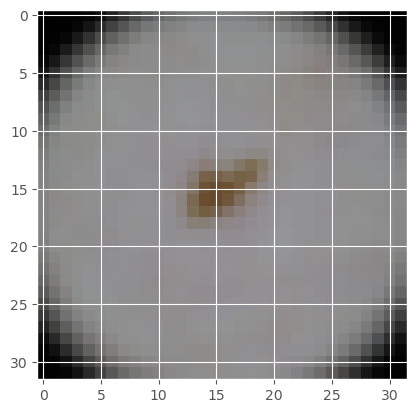

Label: 5


In [11]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.T, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
scaler = GradScaler()
# model = CIFAR10Model()
# model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.AdamW(model.parameters(), lr=0.1, weight_decay=1e-8)

 
n_epochs = 10
for epoch in range(n_epochs):
    tq = tqdm(total=len(train_dataloader) * BATCH_SIZE, position=0, leave=True)
    tq.set_description('Epoch {}/{}'.format(epoch + 1, n_epochs))
    
    model.train()
    train_loss, train_acc = 0, 0
    for inputs, labels in train_dataloader:
    # for inputs, labels in train_dataloader:
        # forward, backward, and then weight update
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        with autocast(enabled=True):
            y_pred = model.forward(inputs)
            loss = loss_fn(y_pred, labels)
            train_loss += loss.item() 
            
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        
        # y_pred = model(inputs)
        # loss = loss_fn(y_pred, labels)
        
        
        # loss.backward()
        # optimizer.step()
        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == labels).sum().item()/len(y_pred)
        
        tq.update(BATCH_SIZE)
        tq.set_postfix(loss='%.6f' % loss)
 
    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)
    tq.close()

    model.eval()
    
    test_loss, test_acc = 0, 0
    
    acc = 0
    count = 0
    val_loss = 0.0
    for inputs, labels in val_dataloader:
    # for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        with autocast(enabled=True):
            y_pred = model.forward(inputs)
            loss = loss_fn(y_pred, labels)
            test_loss += loss.item()
            
        
        # y_pred = model(inputs)
        # loss = loss_fn(y_pred, labels)
        
        # Calculate and accumulate accuracy
        # test_pred_labels = y_pred.argmax(dim=1)
        # test_acc += ((test_pred_labels == labels).item()/len(test_pred_labels))
        test_acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
        
    test_loss = test_loss / len(val_dataloader)
    # test_acc = test_acc / len(val_dataloader)
    
    test_acc /= count
    
    
    # acc /= count
    # val_loss /= count
    print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )
    # print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))
    # print("Epoch %d: model loss %.2f%%" % (epoch, loss))
    
 
torch.save(model.state_dict(), "cifar10model.pth")

Epoch 1/10: 100%|███████████████| 20264/20264 [08:09<00:00, 41.36it/s, loss=nan]


Epoch: 1 | train_loss: nan | train_acc: 0.0342 | test_loss: nan | test_acc: 0.0341


Epoch 2/10:  98%|██████████████▋| 19880/20264 [05:52<00:07, 52.29it/s, loss=nan]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 4/10:  99%|██████████████▊| 20080/20264 [06:36<00:03, 47.72it/s, loss=nan]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 6/10: 100%|███████████████| 20264/20264 [08:08<00:00, 41.45it/s, loss=nan]


Epoch: 6 | train_loss: nan | train_acc: 0.0342 | test_loss: nan | test_acc: 0.0341


Epoch 7/10:  51%|███████▋       | 10328/20264 [03:09<03:11, 51.93it/s, loss=nan]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 9/10:  97%|██████████████▍| 19560/20264 [06:39<00:23, 29.66it/s, loss=nan]

In [ ]:
%%time
# Loop for training

# Training loop
num_epochs = 10

best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
val_loss_hist = []
val_acc_hist = []

# save_best_model = SaveBestModel()
for epoch in range(num_epochs):
    tq = tqdm(total=len(train_dataloader) * BATCH_SIZE, position=0, leave=True)
    tq.set_description('Epoch {}/{}'.format(epoch + 1, num_epochs))
    
    train_epoch_loss = 0.0
    train_epoch_acc = 0.0
    
    model.train()
    for X_train_batch, y_train_batch in train_dataloader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        tq.update(BATCH_SIZE)
        tq.set_postfix(loss='%.6f' % train_loss)

    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        tqe = tqdm(total=len(val_dataloader) * BATCH_SIZE, position=0, leave=True)
        tqe.set_description('Epoch {}/{}'.format(epoch + 1, num_epochs))
        
        model.eval()
        for X_val_batch, y_val_batch in val_dataloader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
            tqe.update(BATCH_SIZE)
            tqe.set_postfix(loss='%.6f' % val_loss)

    val_loss_hist.append(val_epoch_loss)
    val_acc_hist.append(val_epoch_acc)
    # train_losses.append(np.mean(train_epoch_loss))
    # train_accuracies.append(np.mean(train_epoch_acc))
    # val_losses.append(val_epoch_loss)
    # val_accuracies.append(val_epoch_acc)
    
    # print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_epoch_loss:.4f} Val Loss: {val_epoch_loss:.4f}")
    
    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_epoch_loss:.4f} Train Acc: {train_epoch_acc:.2f}% Val Loss: {val_epoch_loss:.4f} Val Acc: {val_epoch_acc:.2f}%")

save_model(num_epochs, model, optimizer, loss_fn, 'results', '27032024_15h')

# # Plotting Training & Validation Loss
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(train_losses, '-x', label='Train')
# plt.plot(val_losses, '-o', label='Val')
# plt.title('Loss vs. No. of epochs')
# plt.legend()

# # Plotting Training & Validation Accuracy
# plt.subplot(1, 2, 2)
# plt.plot(train_accuracies, '-x', label='Train')
# plt.plot(val_accuracies, '-o', label='Val')
# plt.title('Accuracy vs. No. of epochs')
# plt.legend()
# plt.show()

In [ ]:
# copy.deepcopy(model.state_dict())

In [ ]:
# roc_auc = metrics.roc_auc_score(final_targets, final_outputs, multi_class='ovr')

## Performance on Valid/Test Data

In [72]:
# Performance on Valid/Test Data
def overall_accuracy(model, test_loader, criterion):
    
    '''
    Model testing 
    
    Args:
        model: model used during training and validation
        test_loader: data loader object containing testing data
        criterion: loss function used
    
    Returns:
        test_loss: calculated loss during testing
        accuracy: calculated accuracy during testing
        y_proba: predicted class probabilities
        y_truth: ground truth of testing data
    '''
    
    y_proba = []
    y_truth = []
    test_loss = 0
    total = 0
    correct = 0
    for data in tqdm(test_loader):
        # X, y = data[0].to('cpu'), data[1].to('cpu')
        X, y = data[0].to(device), data[1].to(device)
        
        output = model(X)
        test_loss += criterion(output, y.long()).item()
        for index, i in enumerate(output):
            y_proba.append(i[1])
            y_truth.append(y[index])
            if torch.argmax(i) == y[index]:
                correct+=1
            total+=1
                
    accuracy = correct/total
    
    y_proba_out = np.array([float(y_proba[i]) for i in range(len(y_proba))])
    y_truth_out = np.array([float(y_truth[i]) for i in range(len(y_truth))])
    
    return test_loss, accuracy, y_proba_out, y_truth_out


loss, acc, y_proba, y_truth = overall_accuracy(model, val_dataloader, 
                                               criterion = nn.CrossEntropyLoss())


print(f"Accuracy: {acc}")

print(pd.value_counts(y_truth))

100%|█████████████████████████████████████████| 159/159 [01:15<00:00,  2.10it/s]


Accuracy: 0.11328202091967633
5.0    2575
4.0     904
1.0     665
2.0     525
0.0     173
6.0     126
7.0      51
3.0      48
Name: count, dtype: int64


## Plot ROC curve

329.28403663635254

In [ ]:
# Plot ROC curve:

def plot_ROCAUC_curve(y_truth, y_proba, fig_size):
    
    '''
    Plots the Receiver Operating Characteristic Curve (ROC) and displays Area Under the Curve (AUC) score.
    
    Args:
        y_truth: ground truth for testing data output
        y_proba: class probabilties predicted from model
        fig_size: size of the output pyplot figure
    
    Returns: void
    '''
    # fpr, tpr, threshold = roc_auc_score(y_truth, y_proba, multi_class='ovr')
    fpr, tpr, threshold = roc_curve(y_truth, y_proba,pos_label=1)
    auc_score = roc_auc_score(y_truth, y_proba, multi_class='ovr')
    txt_box = "AUC Score: " + str(round(auc_score, 4))
    plt.figure(figsize=fig_size)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'--')
    plt.annotate(txt_box, xy=(0.65, 0.05), xycoords='axes fraction')
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
#     plt.savefig('ROC.png')
plot_ROCAUC_curve(y_truth, y_proba, (8, 8))
# auc = roc_auc_score(y_truth, y_proba, multi_class='ovr')
# print(auc)

In [89]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

# Tpr, Fpr = calculate_tpr_fpr(y_truth, y_proba)


In [20]:
x, y = next(iter(val_dataloader))
prediction = model.predict(x)

predict_label1 = np.argmax(prediction, axis=-1)
true_label1 = np.argmax(y, axis=-1)

y = np.array(true_label1)

# scores = np.array(predict_label1)
# fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=9)
# roc_auc = metrics.auc(fpr, tpr)


# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange',
#  lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic (ROC)')
# plt.legend(loc="lower right")
# plt.show()

AttributeError: 'SwinTransformer' object has no attribute 'predict'